In [1]:
# Import necessary libraries
import glob  # To read file paths
import json  # To work with JSON data

import matplotlib.pyplot as plt  # For plotting graphs
import pandas as pd  # For data manipulation
import datetime as dt  # For handling dates and times

# Define the path where log files are located
LOGPATH = "D:/log"

In [2]:
#  _____      _     _               _ _                 
# |  __ \    | |   | |             | (_)                
# | |  \/ ___| |_  | | ___   __ _  | |_ _ __   ___  ___ 
# | | __ / _ \ __| | |/ _ \ / _` | | | | '_ \ / _ \/ __|
# | |_\ \  __/ |_  | | (_) | (_| | | | | | | |  __/\__ \
#  \____/\___|\__| |_|\___/ \__, | |_|_|_| |_|\___||___/
#                            __/ |                      
#                           |___/                       

# Get a list of all text files in the log path and sort them
# Replace backslashes with forward slashes for consistency
logfiles = sorted(x.replace("\\", "/") for x in glob.glob(LOGPATH + "/*.txt"))

# Initialize a list to store all log lines
loglines = []
# Iterate through each log file path
for p in logfiles:
    # Open each log file in binary read mode
    with open(p, "rb") as fh:
        # Read all lines from the log file, decode from binary to UTF-8, and extend the loglines list
        loglines.extend(x.decode("utf-8") for x in fh.readlines())

In [3]:
#  _____                           _     _              _                   _       
# /  __ \                         | |   | |            | |                 | |      
# | /  \/ ___  _ ____   _____ _ __| |_  | |_ ___    ___| |_ _ __ _   _  ___| |_ ___ 
# | |    / _ \| '_ \ \ / / _ \ '__| __| | __/ _ \  / __| __| '__| | | |/ __| __/ __|
# | \__/\ (_) | | | \ V /  __/ |  | |_  | || (_) | \__ \ |_| |  | |_| | (__| |_\__ \
#  \____/\___/|_| |_|\_/ \___|_|   \__|  \__\___/  |___/\__|_|   \__,_|\___|\__|___/

# Map of device to avaliable timeseries
# [(x, list(data[x].keys())) for x in data]

# [('10.0.0.242', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.243', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.244', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.245', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.246', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.240', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.241', ['ping', 'tcpping', 'rtspping']),
#  ('10.0.0.247', ['ping', 'tcpping', 'rtspping']),
#  ('D:/ftproot', ['ftpbytes']),
#  ('D:/ts_cam0', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam1', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam2', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam3', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam4', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam5', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam6', ['latestfile', 'earliestfile', 'numfiles', 'numbytes']),
#  ('D:/ts_cam7', ['latestfile', 'earliestfile', 'numfiles', 'numbytes'])]

# Initialize a dictionary to store processed log data
data = {}

# Iterate through each line in the collected log lines
for l in loglines:
    # Parse the JSON data from the line
    d = json.loads(l)
    # Extract the time value from the data
    time = d["time"]
    # Remove the time entry from the data dictionary
    del d["time"]
    # Split the first remaining key to get the source and node information
    source, node = list(d)[0].split("_", 1)
    # Retrieve the node data from the main data dictionary, or initialize an empty dict if not present
    node_ = data.get(node, {})  # must be set back to the data
    # Retrieve the source data from the node dictionary, or initialize an empty list if not present
    source_ = node_.get(source, [])  # must be set back to the node
    # Append a tuple of time and the remaining value to the source list
    source_.append((time, d[list(d)[0]]))
    # Update the source list back to the node dictionary
    node_[source] = source_
    # Update the node dictionary back to the main data dictionary
    data[node] = node_

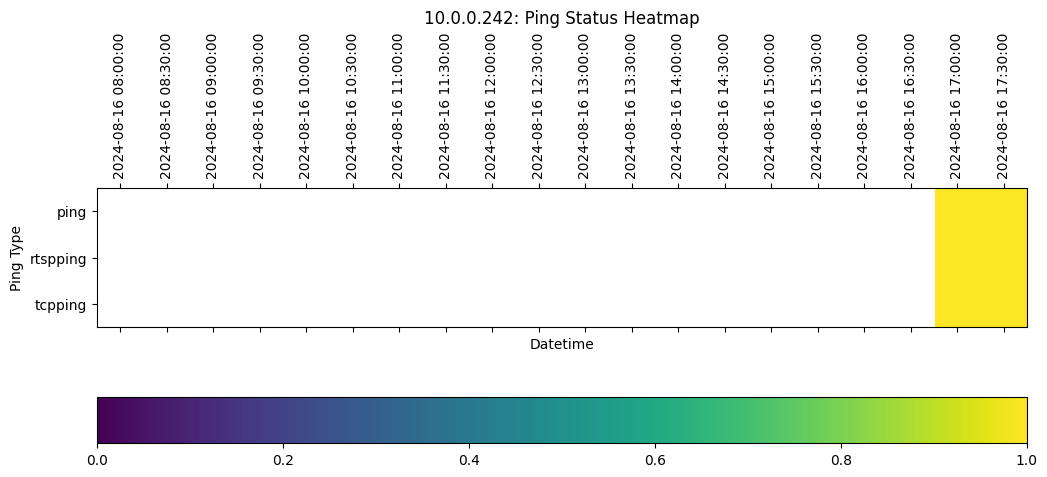

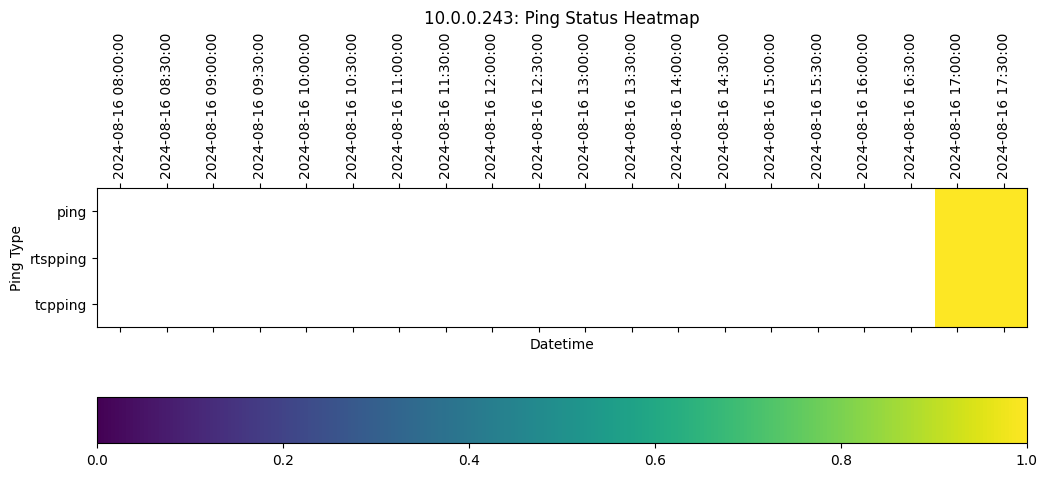

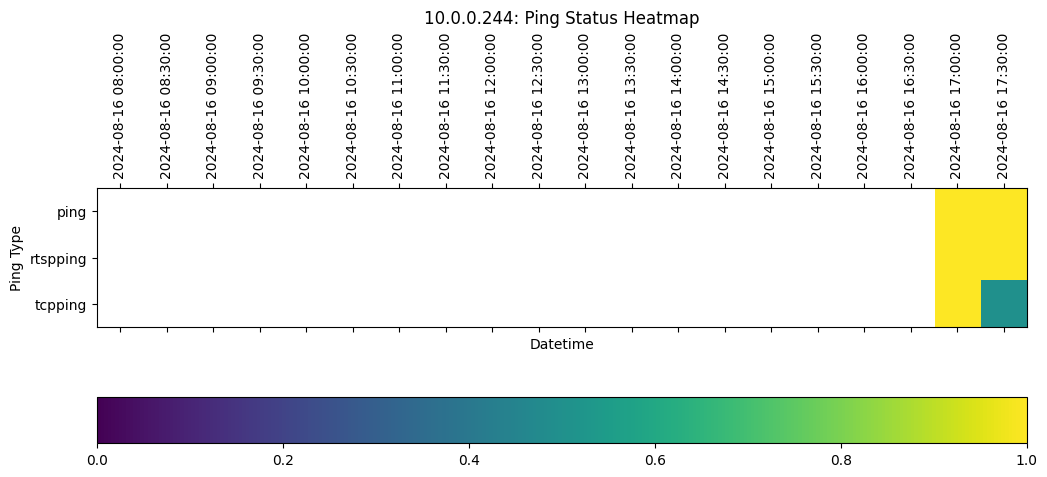

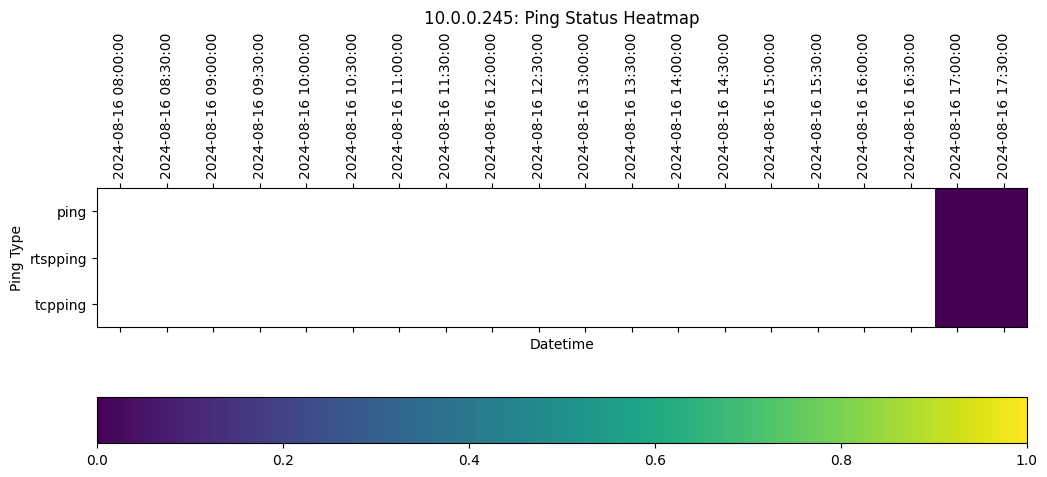

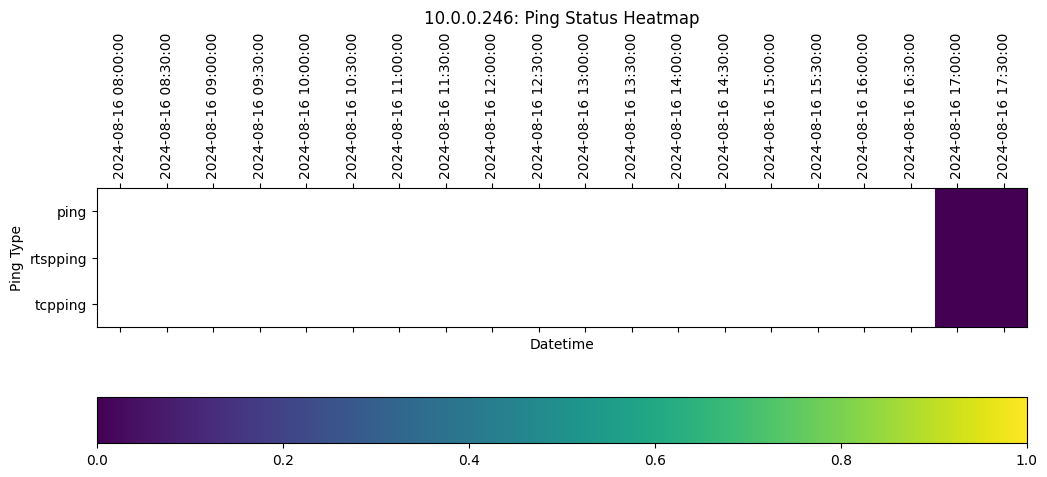

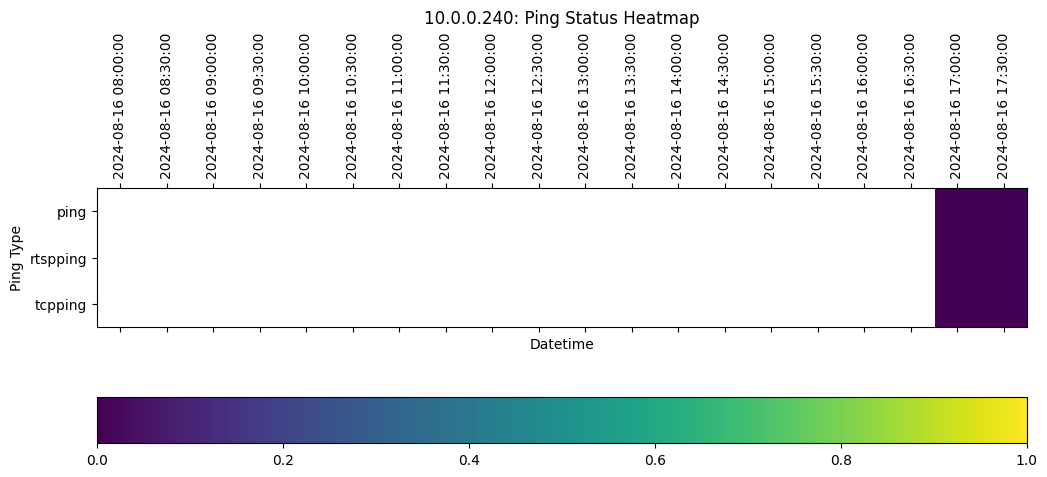

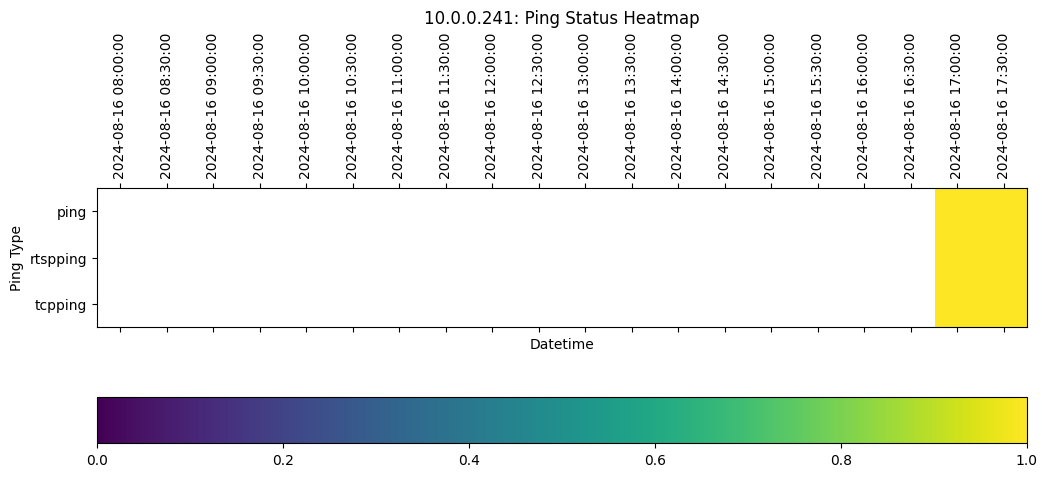

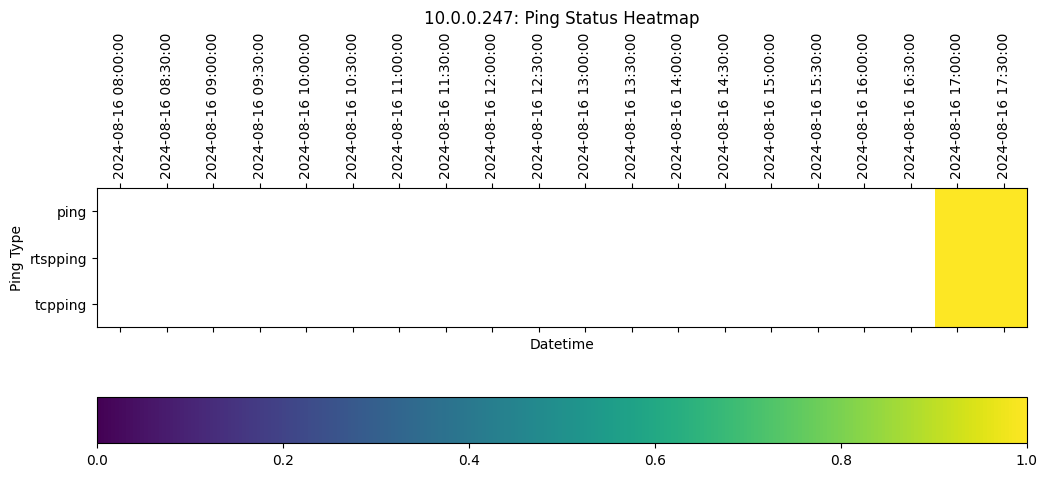

In [4]:
#  _____                           _               _                 _        _             
# |  __ \                         | |             (_)               | |      | |            
# | |  \/ ___ _ __   ___ _ __ __ _| |_ ___   _ __  _ _ __   __ _ ___| |_ __ _| |_ _   _ ___ 
# | | __ / _ \ '_ \ / _ \ '__/ _` | __/ _ \ | '_ \| | '_ \ / _` / __| __/ _` | __| | | / __|
# | |_\ \  __/ | | |  __/ | | (_| | ||  __/ | |_) | | | | | (_| \__ \ || (_| | |_| |_| \__ \
#  \____/\___|_| |_|\___|_|  \__,_|\__\___| | .__/|_|_| |_|\__, |___/\__\__,_|\__|\__,_|___/
#                                           | |             __/ |                           
#                                           |_|            |___/                            

# Iterate over each node in the data dictionary
for node in data:
    # Initialize a list to hold DataFrames
    df_list = []
    # Iterate over the key-value pairs in the current node's data
    for key, values in data[node].items():
        # Skip the key if it doesn't contain the substring "ping"
        if "ping" not in key:
            continue
        # Create a DataFrame with columns datetime and status from values
        temp_df = pd.DataFrame(values, columns=["datetime", "status"])
        # Convert the datetime column to datetime objects
        temp_df["datetime"] = pd.to_datetime(temp_df["datetime"])
        # Add a new column 'type' with the key as its value
        temp_df["type"] = key
        # Convert the status column to 1 for "reachable" and 0 for other statuses
        temp_df["status"] = temp_df["status"].apply(
            lambda x: 1 if x == "reachable" else 0
        )
        # Add the temporary DataFrame to the list of DataFrames
        df_list.append(temp_df)
    # If the df_list is empty (no "ping" data), continue to the next node
    if not df_list:
        continue
    # Combine all the DataFrames in df_list into a single DataFrame
    df = pd.concat(df_list)

    # Pivot the DataFrame so that datetime is the index, types are columns, and status are values
    pivot_df = df.pivot(index="datetime", columns="type", values="status")
    # Resample the DataFrame to 30-minute intervals and calculate the mean status
    pivot_df = pivot_df.resample("30min").mean().T.iloc[:, -20:]

    # Create a heatmap plot
    fig, ax = plt.subplots(figsize=(12, 6))
    # Create a matrix plot of the pivoted DataFrame with color intensity based on status
    cax = ax.matshow(pivot_df, vmin=0, vmax=1)
    # Add a colorbar to the plot with a horizontal orientation
    fig.colorbar(cax, orientation="horizontal")
    # Set the title of the plot to include the node name
    plt.title(f"{node}: Ping Status Heatmap")
    # Label the x-axis as "Datetime"
    plt.xlabel("Datetime")
    # Set the x-tick labels to the datetime values, rotated 90 degrees for readability
    plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=90)
    # Label the y-axis as "Ping Type"
    plt.ylabel("Ping Type")
    # Set the y-tick labels to the ping types
    plt.yticks(range(len(pivot_df.index)), pivot_df.index)

    # Display the plot
    plt.show()

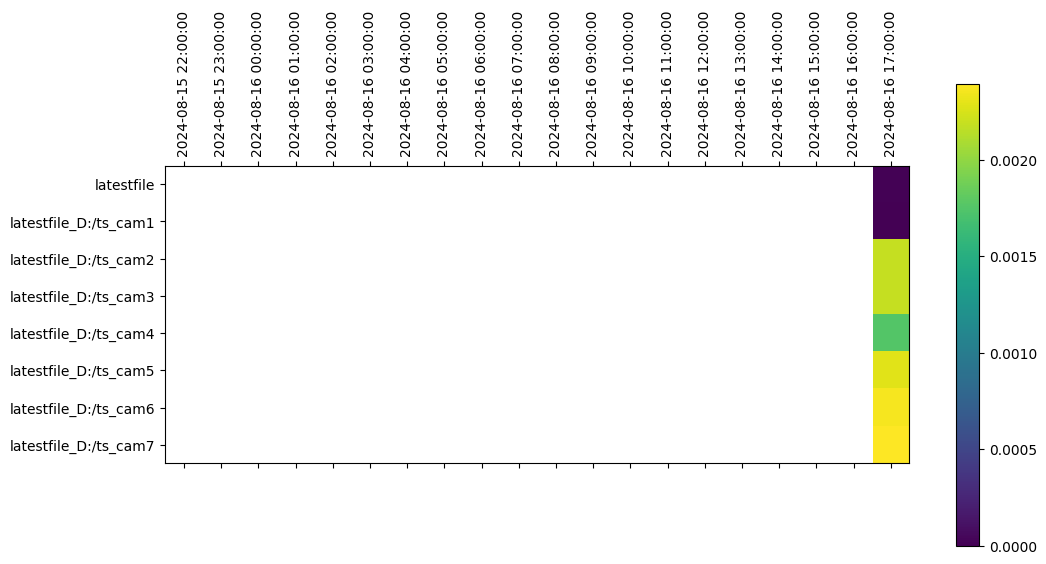

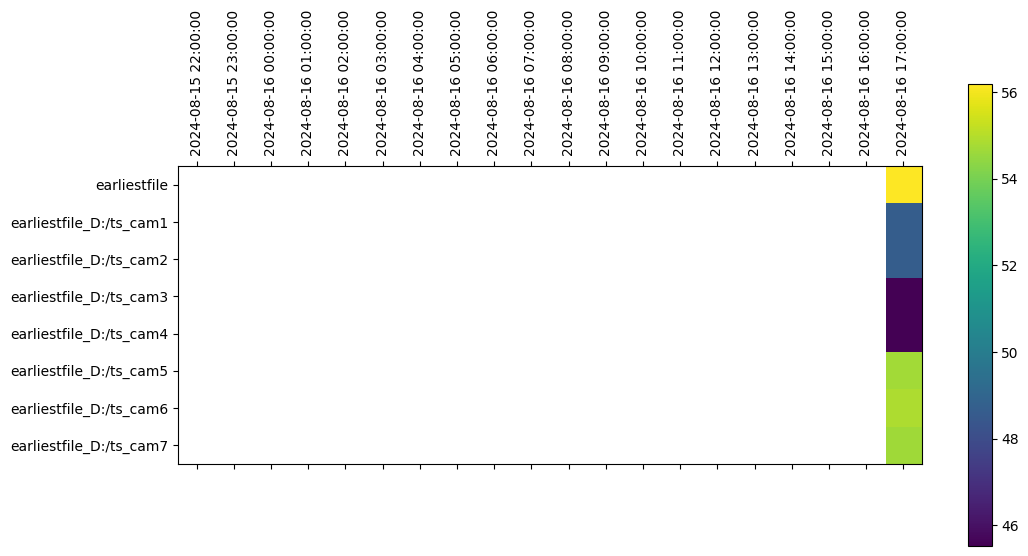

In [5]:
# Initialize an empty variable to hold the final merged DataFrame
df_list2 = None

# Iterate through each node in the 'data' dictionary
for node in data:
    # Initialize an empty list to hold temporary DataFrames
    df_list = []

    # Iterate through each key and its corresponding values in the current node's dictionary
    for key, values in data[node].items():
        # Skip processing if the key contains certain strings
        if "ping" in key:
            continue
        if "bytes" in key:
            continue
        if "files" in key:
            continue

        # Create a DataFrame from the values with specified column names
        temp_df = pd.DataFrame(values, columns=["datetime", "status"])
        # Add a new column 'type' with the key as its value
        temp_df["type"] = key
        # Calculate the difference in days between 'datetime' and 'status' columns
        # and replace the 'status' column with this value
        temp_df["status"] = temp_df[["status", "datetime"]].apply(
            lambda x: (
                dt.datetime.strptime(x.datetime, "%Y-%m-%d %H:%M:%S")
                - dt.datetime.strptime(x.status, "%Y-%m-%d %H:%M:%S")
            ).total_seconds()
            / (3600 * 24),
            axis=1,
        )
        # Convert the 'datetime' column to pandas datetime objects
        temp_df["datetime"] = pd.to_datetime(temp_df["datetime"])
        # Append the temporary DataFrame to the list of DataFrames
        df_list.append(temp_df)

    # Skip the rest of the loop if the list of DataFrames is empty
    if not df_list:
        continue

    # Concatenate all DataFrames in the list, pivot the resulting DataFrame
    # to have 'datetime' as index and 'type' as columns, then resample by 1 hour
    # and calculate the mean of 'status' values
    df = (
        pd.concat(df_list)
        .pivot(index="datetime", columns="type", values="status")
        .resample("1h")
        .mean()
    )

    # Merge the current DataFrame 'df' with the final DataFrame 'df_list2'
    # If 'df_list2' is not None, merge them using their indexes and add a suffix to
    # the column names from the current node, otherwise set 'df_list2' to the current 'df'
    df_list2 = (
        pd.merge(
            df_list2, df, left_index=True, right_index=True, suffixes=(None, "_" + node)
        )
        if df_list2 is not None
        else df
    )

# Select columns from df_list2 that contain the word "latest" and transpose the resulting DataFrame
# Then, slice the last 20 rows of the transposed DataFrame
df_list3 = df_list2[[x for x in df_list2.columns if "latest" in x]].T.iloc[:, -20:]

# Create a figure and a set of subplots with a specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Create a heatmap (matrix plot) of df_list3 and assign the plot to cax
cax = ax.matshow(df_list3)

# Add a colorbar to the figure to show the color scale
fig.colorbar(cax)

# Set the x-axis ticks to be the column names of df_list3 with a 90-degree rotation for readability
plt.xticks(range(len(df_list3.columns)), df_list3.columns, rotation=90)

# Set the y-axis ticks to be the index (row labels) of df_list3
plt.yticks(range(len(df_list3.index)), df_list3.index)

# Display the plot
plt.show()

# The following code block repeats the same process as above but for columns containing "earliest"
# Select columns from df_list2 that contain the word "earliest" and transpose the resulting DataFrame
# Then, slice the last 20 rows of the transposed DataFrame
df_list4 = df_list2[[x for x in df_list2.columns if "earliest" in x]].T.iloc[:, -20:]

# Create a figure and a set of subplots with a specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Create a heatmap (matrix plot) of df_list4 and assign the plot to cax
cax = ax.matshow(df_list4)

# Add a colorbar to the figure to show the color scale
fig.colorbar(cax)

# Set the x-axis ticks to be the column names of df_list4 with a 90-degree rotation for readability
plt.xticks(range(len(df_list4.columns)), df_list4.columns, rotation=90)

# Set the y-axis ticks to be the index (row labels) of df_list4
plt.yticks(range(len(df_list4.index)), df_list4.index)

# Display the plot
plt.show()

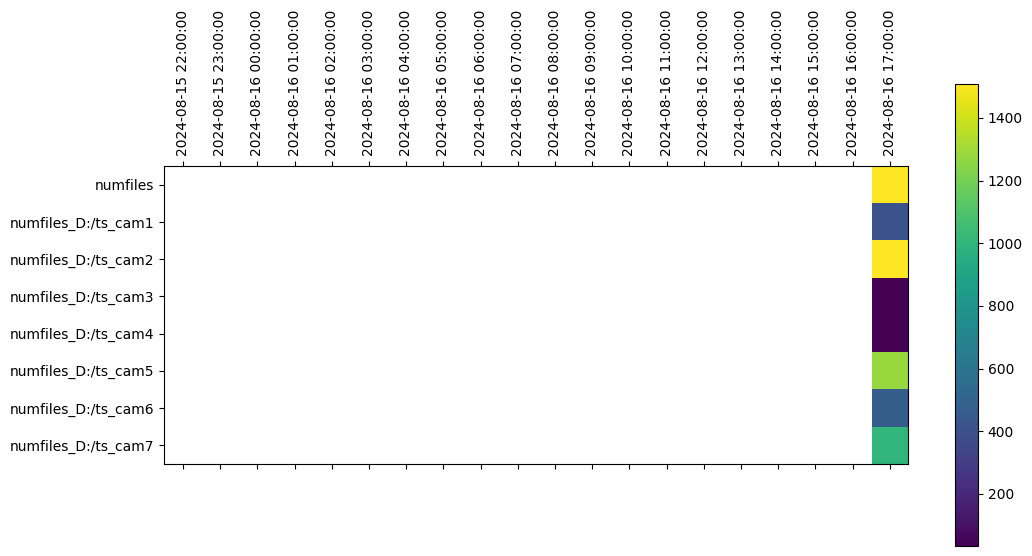

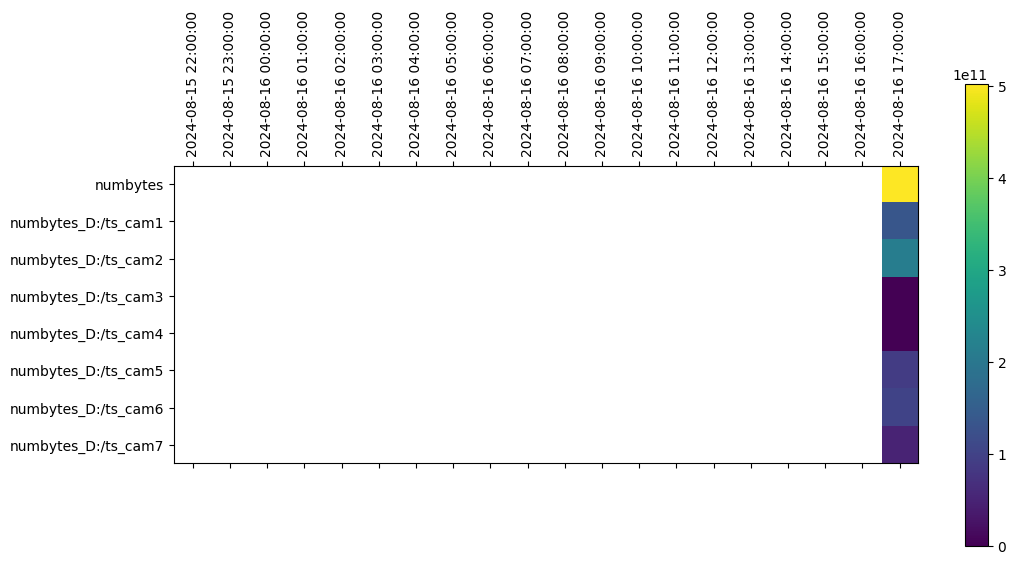

In [6]:
#  _____                           _               _                 _        _             
# |  __ \                         | |             (_)               | |      | |            
# | |  \/ ___ _ __   ___ _ __ __ _| |_ ___   _ __  _ _ __   __ _ ___| |_ __ _| |_ _   _ ___ 
# | | __ / _ \ '_ \ / _ \ '__/ _` | __/ _ \ | '_ \| | '_ \ / _` / __| __/ _` | __| | | / __|
# | |_\ \  __/ | | |  __/ | | (_| | ||  __/ | |_) | | | | | (_| \__ \ || (_| | |_| |_| \__ \
#  \____/\___|_| |_|\___|_|  \__,_|\__\___| | .__/|_|_| |_|\__, |___/\__\__,_|\__|\__,_|___/
#                                           | |             __/ |                           
#                                           |_|            |___/                            

# Initialize an empty variable to hold the final merged DataFrame
df_list2 = None

# Iterate through each node in the 'data' dictionary
for node in data:
    # Initialize an empty list to hold temporary DataFrames
    df_list = []

    # Iterate through each key and its corresponding values in the current node's dictionary
    for key, values in data[node].items():
        # Skip processing if the key contains certain strings
        if "ping" in key:
            continue
        if "earliest" in key:
            continue
        if "latest" in key:
            continue

        # Create a DataFrame from the values with specified column names
        temp_df = pd.DataFrame(values, columns=["datetime", "status"])
        # Add a new column 'type' with the key as its value
        temp_df["type"] = key
        # Calculate the difference in days between 'datetime' and 'status' columns
        # and replace the 'status' column with this value
        # temp_df["status"] = temp_df[["status", "datetime"]].apply(
        #     lambda x: (
        #         dt.datetime.strptime(x.datetime, "%Y-%m-%d %H:%M:%S")
        #         - dt.datetime.strptime(x.status, "%Y-%m-%d %H:%M:%S")
        #     ).total_seconds()
        #     / (3600 * 24),
        #     axis=1,
        # )
        temp_df["status"] = temp_df["status"].astype('int64')
        # Convert the 'datetime' column to pandas datetime objects
        temp_df["datetime"] = pd.to_datetime(temp_df["datetime"])
        # Append the temporary DataFrame to the list of DataFrames
        df_list.append(temp_df)

    # Skip the rest of the loop if the list of DataFrames is empty
    if not df_list:
        continue

    # Concatenate all DataFrames in the list, pivot the resulting DataFrame
    # to have 'datetime' as index and 'type' as columns, then resample by 1 hour
    # and calculate the mean of 'status' values
    df = (
        pd.concat(df_list)
        .pivot(index="datetime", columns="type", values="status")
        .resample("1h")
        .mean()
    )

    # Merge the current DataFrame 'df' with the final DataFrame 'df_list2'
    # If 'df_list2' is not None, merge them using their indexes and add a suffix to
    # the column names from the current node, otherwise set 'df_list2' to the current 'df'
    df_list2 = (
        pd.merge(
            df_list2, df, left_index=True, right_index=True, suffixes=(None, "_" + node)
        )
        if df_list2 is not None
        else df
    )

# Select columns from df_list2 that contain the word "latest" and transpose the resulting DataFrame
# Then, slice the last 20 rows of the transposed DataFrame
df_list3 = df_list2[[x for x in df_list2.columns if "numfiles" in x]].T.iloc[:, -20:]

# Create a figure and a set of subplots with a specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Create a heatmap (matrix plot) of df_list3 and assign the plot to cax
cax = ax.matshow(df_list3)

# Add a colorbar to the figure to show the color scale
fig.colorbar(cax)

# Set the x-axis ticks to be the column names of df_list3 with a 90-degree rotation for readability
plt.xticks(range(len(df_list3.columns)), df_list3.columns, rotation=90)

# Set the y-axis ticks to be the index (row labels) of df_list3
plt.yticks(range(len(df_list3.index)), df_list3.index)

# Display the plot
plt.show()

# The following code block repeats the same process as above but for columns containing "earliest"
# Select columns from df_list2 that contain the word "earliest" and transpose the resulting DataFrame
# Then, slice the last 20 rows of the transposed DataFrame
df_list4 = df_list2[[x for x in df_list2.columns if 'numbytes' in x]].T.iloc[:, -20:]

# Create a figure and a set of subplots with a specified size
fig, ax = plt.subplots(figsize=(12, 6))

# Create a heatmap (matrix plot) of df_list4 and assign the plot to cax
cax = ax.matshow(df_list4)

# Add a colorbar to the figure to show the color scale
fig.colorbar(cax)

# Set the x-axis ticks to be the column names of df_list4 with a 90-degree rotation for readability
plt.xticks(range(len(df_list4.columns)), df_list4.columns, rotation=90)

# Set the y-axis ticks to be the index (row labels) of df_list4
plt.yticks(range(len(df_list4.index)), df_list4.index)

# Display the plot
plt.show()